In [13]:
from __future__ import division, print_function

import GPy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from safe_learning import *

We start by defining a discretization of the space $[-1, 1]$ with discretization constant $\tau$

In [14]:
# Discretization constant
tau = 0.001

# x_min, x_max, discretization
grid_param = [-1., 1., tau]

extent = np.array(grid_param[:2])

# Create a grid
grid = np.arange(*grid_param)[:, None]
num_samples = len(grid)

print('Grid size: {0}'.format(len(grid)))

Grid size: 2000


### Draw system dynamics from a GP

We define a kernel, $k(x,x') = k_{\mathrm{linear}}(x, x') * k_{\mathrm{Matern}}(x, x')$, which models a nonlinear, 2-times differentiable function with linearly increasing amplitude. We draw a sample from this kernel in order to define the dynamics.

The following plot shows the kind of functions that this kernel implies

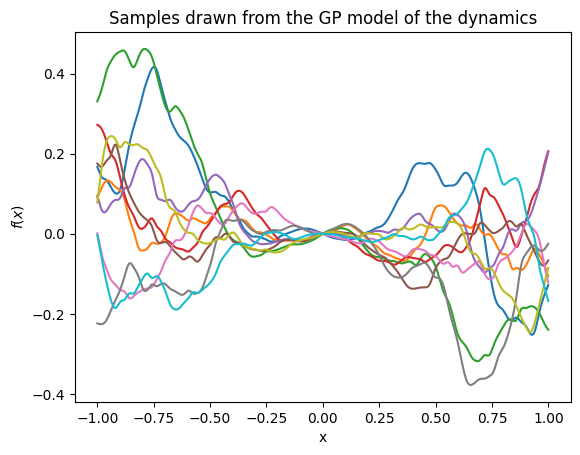

In [15]:
kernel = GPy.kern.Matern32(1, lengthscale=0.2, variance=0.2**2) * GPy.kern.Linear(1)

for i in range(10):
    f = sample_gp_function(kernel,
                           [extent],
                           num_samples=100,
                           noise_var=0.1,
                           interpolation='kernel')
    plt.plot(grid, f(grid, noise=False))

plt.ylabel('$f(x)$')
plt.xlabel('x')
plt.title('Samples drawn from the GP model of the dynamics')
plt.show()

We define the GP model using one particular sample of the GP, in addition to a stable, closed-loop, linear model.
$$\dot{x} = -0.25 x + g_\pi(x),$$

The prior dynamics are locally asymptotically stable. Moreover, in the one-dimensional case, the dynamics are stable as long as $\dot{x} > 0$ if $x<0$ and $\dot{x} < 0$ if $x>0$.

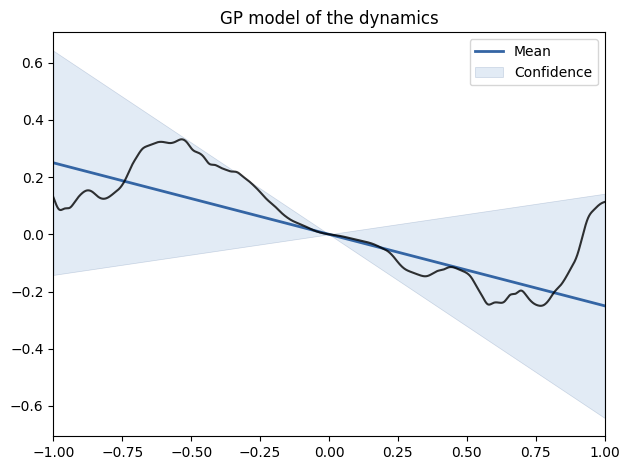

In [16]:
# Observation noise
noise_var = 0.01 ** 2

# Mean dynamics
mf = GPy.core.Mapping(1, 1)
mf.f = lambda x: -0.25 * x
mf.update_gradients = lambda a, b: None

# Define one sample as the true dynamics
np.random.seed(5)
true_dynamics = sample_gp_function(kernel,
                                   [extent],
                                   num_samples=100,
                                   noise_var=noise_var,
                                   interpolation='kernel',
                                   mean_function=mf.f)

gp = GPy.core.GP(np.array([[0]]), np.array([[0]]),
                 kernel, GPy.likelihoods.Gaussian(variance=noise_var),
                 mean_function=mf)

gp.plot_f(plot_limits=extent)
plt.plot(grid, true_dynamics(grid, noise=False), color='black', alpha=0.8)
plt.title('GP model of the dynamics')
plt.show()

Additionally we define a random lyapunov function. Unlike for multiple dimensions, in the one-dimensional case all radially increasing functions are equivalent. Here we pick
$$V(x) = x^2$$
The previous GP model defines a GP model over $\dot{V}(x) = \frac{\partial V(x)}{\partial x} f(x)$. In the following, we only consider the 2-$\sigma$ upper confidence bound of this model. Since the dynamics are Lipschitz continuous, $\dot{V}$ is Lipschitz continuous as well.

In particular, we use Lemma 5 to determine an appropriate Lipschitz constant. For the sample path of the GP, we use the high-probability Lipschitz constant encoded by the kernel.

In [17]:
lyapunov_function = lambda x: quadratic_lyapunov_function(x, np.array([[1]]))
V, dV = lyapunov_function(grid)

# V, dV = lyapunov(grid)
accuracy = np.max(V) / 1e10
beta = 2

# Lipschitz constant
L_dyn = 0.25 + beta * np.sqrt(gp.kern.Mat32.variance) / gp.kern.Mat32.lengthscale * np.max(np.abs(extent))
B_dyn = (0.25 + np.sqrt(gp.kern.Mat32.variance)) * np.max(np.abs(extent))
B_dV = L_V = np.max(dV)
L_dV = 1

L = B_dyn * L_dV + B_dV * L_dyn

## Safety based on GP model
Let's write a plotting script for the GP model:

In [18]:
def plot_model(S, beta=2, legend=False):    
    # Create figure axes
    fig, axes = plt.subplots(2, 1, figsize=(10, 12))
    
    # Format axes
    axes[0].set_title('GP model of the dynamics')
    axes[1].set_xlim(extent)
    axes[1].set_xlabel('$x$')
    axes[1].set_ylabel(r'Upper bound of $\dot{V}(x)$')
    axes[1].set_title(r'Determining stability with $\dot{V}(x)$')
    
    # Lyapunov function
    V, dV = lyapunov_function(grid)
    mean, var = gp._raw_predict(grid)
    V_dot_mean, V_dot_var = compute_v_dot_distribution(dV, mean, var)

    # Plot dynamics
    axes[0].plot(grid, true_dynamics(grid, noise=False), color='black', alpha=0.8)
    
    axes[0].fill_between(grid[:, 0],
                         mean[:, 0] + beta * np.sqrt(var[:, 0]),
                         mean[:, 0] - beta * np.sqrt(var[:, 0]),
                         color=(0.8, 0.8, 1))
    axes[0].plot(gp.X, gp.Y, 'x', ms=8, mew=2)

    # Plot V_dot
    v_dot_est_plot = plt.fill_between(grid.squeeze(),
                                      V_dot_mean + beta * np.sqrt(V_dot_var),
                                      V_dot_mean - beta * np.sqrt(V_dot_var),
                                      color=(0.8, 0.8, 1))
    threshold = plt.plot(extent, [-L*tau, -L*tau], 'k-.', label=r'Safety threshold ($L \tau$ )')
    v_dot_true_plot = axes[1].plot(grid, dV * true_dynamics(grid, noise=False), 'k',
                                   label=r'True $\dot{V}(x)$')

    # Create twin axis
    ax2 = axes[1].twinx()
    ax2.set_ylabel(r'$V(x)$')
    ax2.set_xlim(extent)
    
    # Plot Lyapunov function
    V_unsafe = np.ma.masked_where(S, V)
    V_safe = np.ma.masked_where(~S , V)
    unsafe_plot = ax2.plot(grid, V_unsafe, 'b', label=r'$V(x)$ (unsafe, $\dot{V}(x) > L \tau$)')
    safe_plot = ax2.plot(grid, V_safe, 'r', label=r'$V(x)$ (safe, $\dot{V}(x) \leq L \tau$)')

    if legend:
        lns = unsafe_plot + safe_plot + threshold + v_dot_true_plot
        labels = [x.get_label() for x in lns]
        plt.legend(lns, labels, loc=4, fancybox=True, framealpha=0.75)
    
    # Create helper lines
    if np.any(S):
        x_safe = grid[S][np.argmax(V[S])]
        y_range = axes[1].get_ylim()
        axes[1].plot([x_safe, x_safe], y_range, 'k-.')
        axes[1].plot([-x_safe, -x_safe], y_range, 'k-.')
        
    # Show plot
    plt.show()

Let's start by plotting the prior over the dynamics and the associated prior over $\dot{V}(x)$.

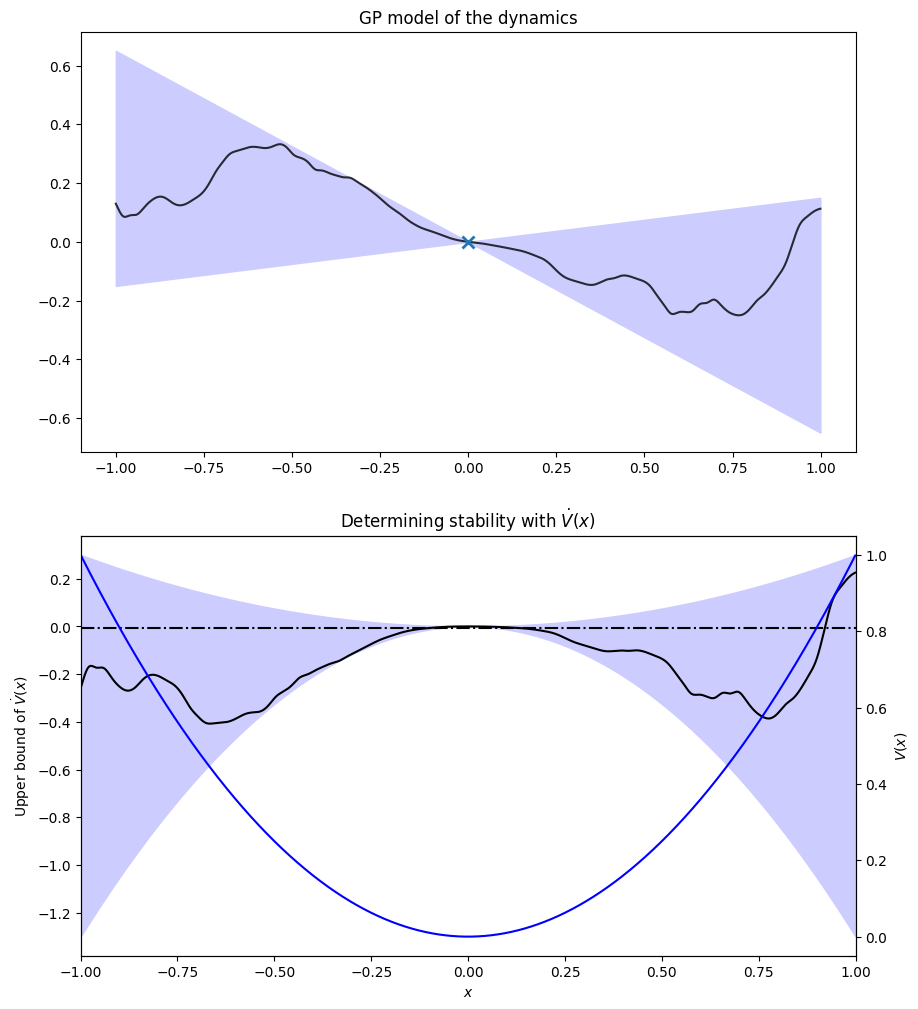

In [19]:
mean, var = gp._raw_predict(grid)
V_dot_mean, V_dot_var = compute_v_dot_distribution(dV, mean, var)
S = get_safe_set(V_dot_mean + beta * np.sqrt(V_dot_var),
                 -L*tau,
                 S0=None)

plot_model(S)

Clearly the model does not allow us to classify any states as safe ($\dot{V} < -L \tau$). However, as a starting point, we assume that we know that the system is asymptotially stable within some initial set, $\mathcal{S}_0$:

$$\mathcal{S}_0 = \{ x \in \mathbb{R} \,|\, |x| < 0.2 \}$$

In [20]:
S0 = np.abs(grid.squeeze()) < 0.2

## Online learning
As we sample within this initial safe set, we gain more knowledge about the system. In particular, we iteratively select the state withing the safe set, $\mathcal{S}_n$, where the dynamics are the most uncertain (highest variance).

In [21]:
def get_max_level_set(dynamics_mean, dynamics_var):
    V_dot = compute_v_dot_upper_bound(dV, dynamics_mean, dynamics_var, beta=2.)
    S = get_safe_set(V_dot, -L*tau, S0=S0)
    c = find_max_levelset(S, V, accuracy)
    S[:] = V <= c
    return S

def update_gp():
    dynamics_mean, dynamics_var = gp._raw_predict(grid)
    S = get_max_level_set(dynamics_mean, dynamics_var)
    max_id = np.argmax(dynamics_var[S])
    max_state = grid[S][[max_id], :].copy()
    gp.set_XY(np.vstack([gp.X, max_state]),
              np.vstack([gp.Y, true_dynamics(max_state, noise=True)[:, [0]]]))
    return S

In [22]:
# Update the GP model a couple of times
for i in range(4):
    update_gp()

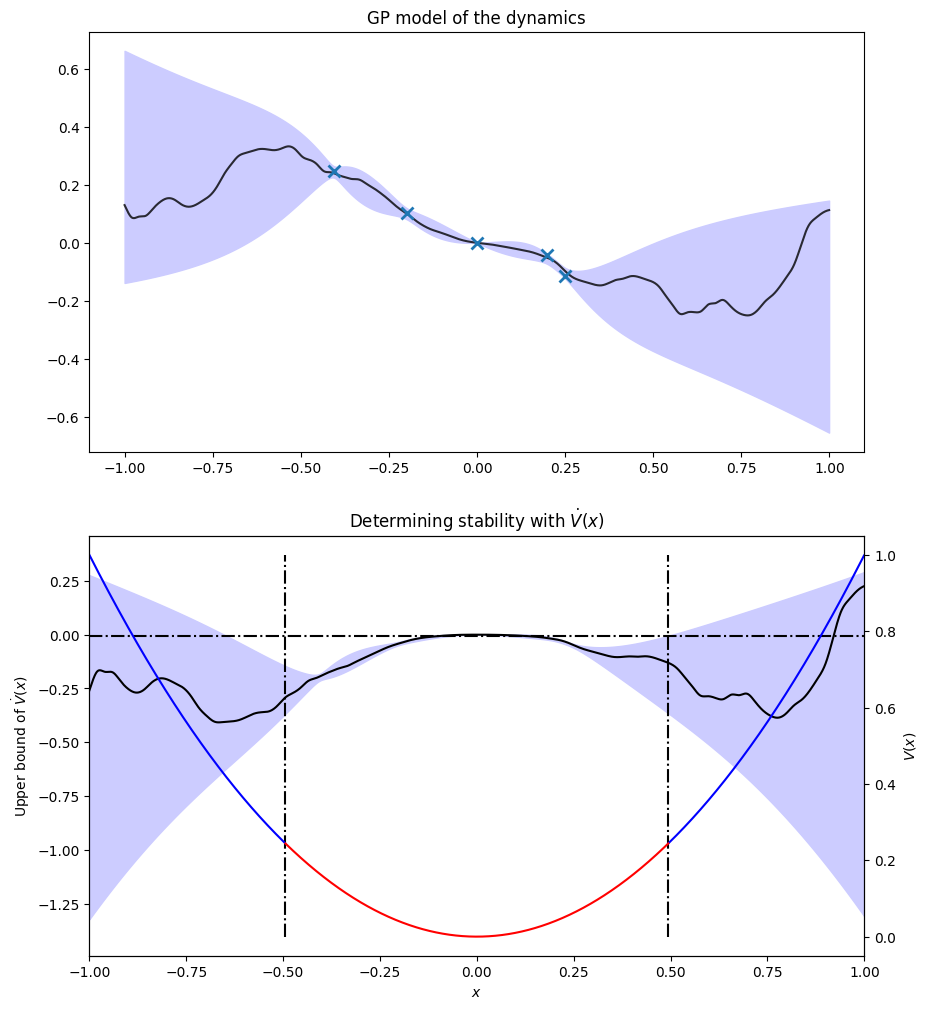

In [23]:
# Plot the new safe set
S = get_max_level_set(*gp._raw_predict(grid))
plot_model(S)

We continue to sample like this, until we find the maximum safe set

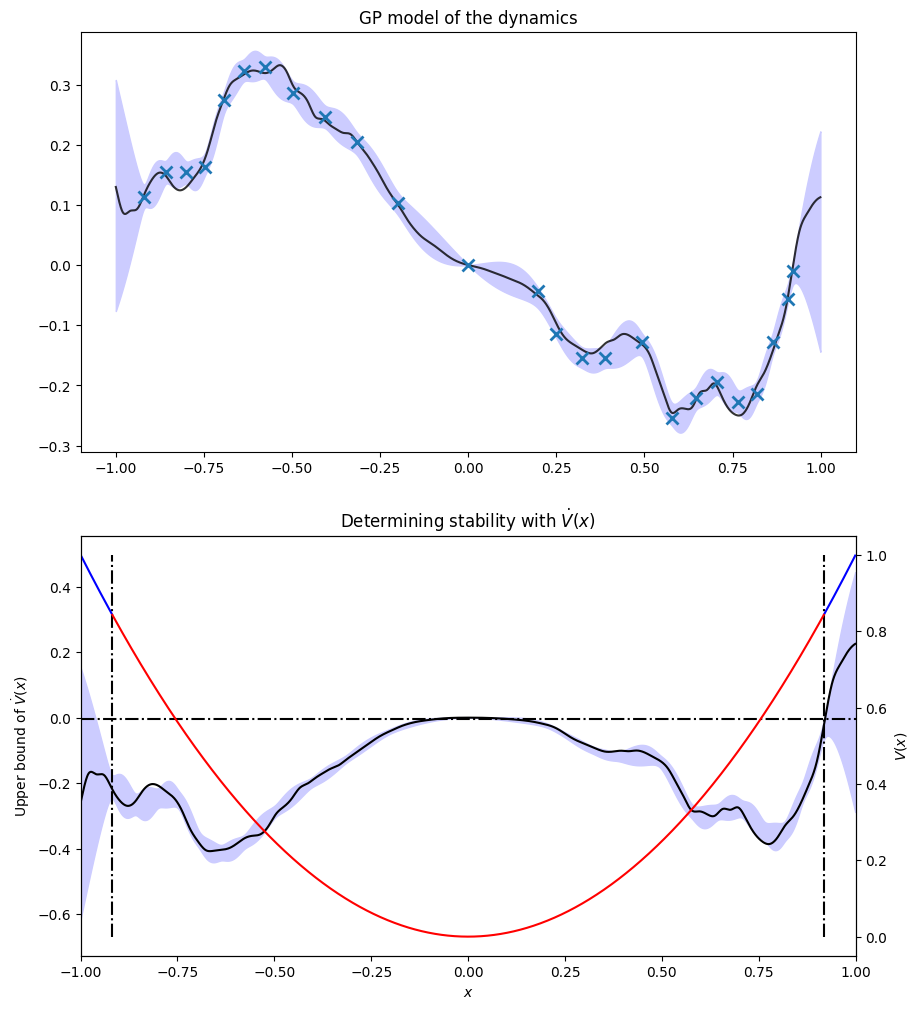

In [24]:
for i in range(20):
    update_gp()

S = get_max_level_set(*gp._raw_predict(grid))
plot_model(S)